In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import os
import xml.dom.minidom

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [2]:
import tensorflow as tf

# Set the dimensions for resizing
height, width = 1024, 1024  # Size to which input image needs to resize

def mapping(file_path):
    """
    Map function to process image and its corresponding cell mask.
    """
    # Modify paths for cell masks
    mask_path = tf.strings.regex_replace(file_path, 'val_1', 'output_mask_1')
    mask_path = tf.strings.regex_replace(mask_path, '.png', '_mask.png')


    # Reading, resizing, and normalizing the table images
    images = tf.io.read_file(file_path)
    images = tf.image.decode_png(images, channels=3)  # Decode a PNG-encoded image to a uint8 tensor
    images = tf.image.resize(images, [height, width])  # Resize to model input size
    images = tf.cast(images, tf.float32) / 255.0  # Normalize image to [0, 1]

    # Reading, resizing, and normalizing the cell mask data
    cell_mask = tf.io.read_file(mask_path)
    cell_mask = tf.image.decode_png(cell_mask, channels=1)  # Decode as grayscale (1 channel)
    cell_mask = tf.image.resize(cell_mask, [height, width])  # Resize to match model input size
    cell_mask = tf.cast(cell_mask, tf.float32) / 255.0  # Normalize to [0, 1]

    return images, {"cell_mask": cell_mask}
def data_pipeline(dataset, input, batch_size=1):
    """
    Create a data pipeline for training or testing with efficient preprocessing.
    """
    # Set AUTOTUNE for efficient data loading
    autotune = tf.data.experimental.AUTOTUNE

    # Calculate the total size of the dataset
    total_size = len(list(dataset))
    proportion = 0.9  # Proportion of data for training
    input_data_size = int(proportion * total_size)

    if input == 'train':
        # Take the training portion of the dataset
        input_data = dataset.take(input_data_size)

        # Map the dataset using the provided mapping function
        input_data = input_data.map(mapping, num_parallel_calls=autotune)
        train_data = input_data

        # Cache the data to improve performance during multiple epochs
        input_data = input_data.cache()

        # Shuffle the data to ensure randomness
        buffer_size = input_data_size
        input_data = input_data.shuffle(buffer_size)

        # Batch the data
        input_data = input_data.batch(batch_size)

        # Repeat the dataset indefinitely for training
        input_data = input_data.repeat()

        # Prefetch to improve performance
        input_data = input_data.prefetch(buffer_size=autotune)

        return input_data, train_data

    else:
        # Take the testing portion of the dataset by skipping the training portion
        input_data = dataset.skip(input_data_size)

        # Map the dataset using the provided mapping function
        input_data = input_data.map(mapping, num_parallel_calls=autotune)
        test_data = input_data

        # Cache the data to improve performance
        input_data = input_data.cache()

        # Shuffle the test data with a buffer size
        buffer_size = total_size - input_data_size
        input_data = input_data.shuffle(buffer_size)

        # Batch the data
        input_data = input_data.batch(batch_size)

        # Repeat the dataset to prevent running out of data during validation
        input_data = input_data.repeat()

        # Prefetch to improve data loading performance
        input_data = input_data.prefetch(buffer_size=autotune)

        return input_data, test_data


In [3]:
dataset = tf.data.Dataset.list_files("/kaggle/input/novelty-3/Novetly_1/val_1/*.png")

In [4]:
train_dataloader, train_data = data_pipeline(dataset, 'train', batch_size=1)
test_dataloader, test_data = data_pipeline(dataset, 'test', batch_size=1)


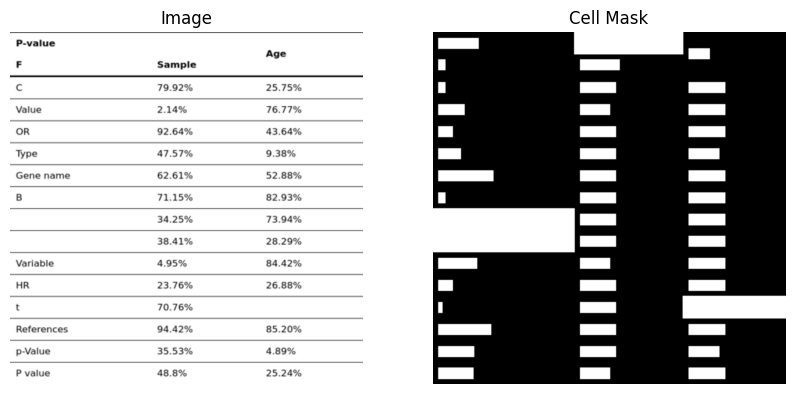

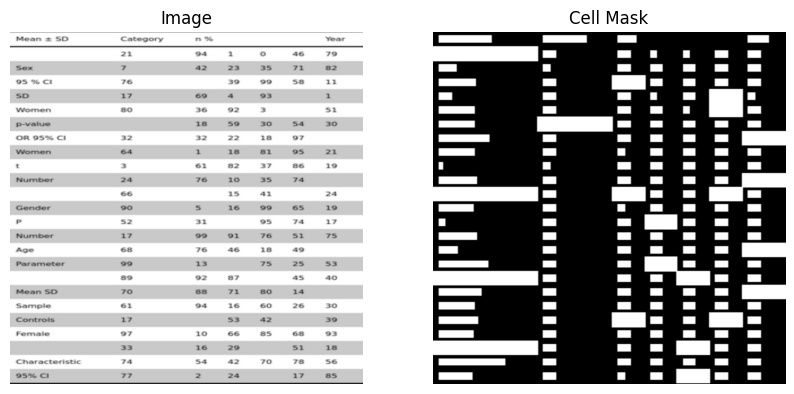

In [5]:
number = 2  # Number of samples to visualize
for image, mask in test_data.take(number):
    plt.figure(figsize=(10, 10))

    # Define the list of items to visualize and their titles
    lists = [image, mask['cell_mask']]
    titles = ['Image', 'Cell Mask']

    for i in range(len(lists)):
        plt.subplot(1, len(lists), i + 1)
        plt.title(titles[i])

        # Convert tensors to displayable images
        plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]), cmap='gray' if i > 0 else None)
        plt.axis('off')

    plt.show()


In [6]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.utils import register_keras_serializable

# Register the custom layer with Keras
@register_keras_serializable(package="Custom", name="cell_decoder")
class cell_decoder(tf.keras.layers.Layer):
    def __init__(self, name="cell_mask", trainable=True, dtype=None, **kwargs):
        super().__init__(name=name, trainable=trainable, dtype=dtype, **kwargs)
        self.conv1 = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')
        self.drop = Dropout(0.8)
        self.conv2 = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2, 2))
        self.upsample4 = UpSampling2D(size=(2, 2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same', name='cell_mask')

    def call(self, X):
        input, pool_3, pool_4 = X[0], X[1], X[2]
        result = self.conv1(input)
        result = self.drop(result)
        result = self.conv2(result)
        result = self.upsample1(result)
        result = Concatenate()([result, pool_4])
        result = self.upsample2(result)
        result = Concatenate()([result, pool_3])
        result = self.upsample3(result)
        result = self.upsample4(result)
        result = self.convtraspose(result)
        return result


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

# Input size for all images: 1024x1024 with three channels
inputShape = (1024, 1024, 3)
inputs = Input(shape=inputShape, name='input')

# Importing pre-trained VGG19 model up to the bottleneck
vgg_19 = tf.keras.applications.VGG19(input_tensor=inputs, include_top=False, weights='imagenet', pooling=None)

# Adding two (1x1) convolutional layers followed by dropout
x = Conv2D(512, (1, 1), activation='relu', name='block6_conv1')(vgg_19.output)
x = Dropout(0.8, name='block6_dropout1')(x)
x = Conv2D(512, (1, 1), activation='relu', name='block6_conv2')(x)
x = Dropout(0.8, name='block6_dropout2')(x)

# Taking 3rd and 4th max-pool layers from VGG19 for the decoder
block3_pool = vgg_19.get_layer('block3_pool').output
block4_pool = vgg_19.get_layer('block4_pool').output


# Encoder result
encoder_result = [x, block3_pool, block4_pool]

# Instantiate the Cell Decoder
Cell_Decoder = cell_decoder()

# Output from the decoder
output = Cell_Decoder(encoder_result)

# Define the model
model = Model(inputs=inputs, outputs=output, name="cellnet")

# Visualize the model structure
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "cellnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1024,      │          0 │ -                 │
│                     │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 1024,      │      1,792 │ input[0][0]       │
│ (Conv2D)            │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 1024,      │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 512, 512,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 512, 512,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 512, 512,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 256, 256,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 256, 256,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 256, 256,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 256, 256,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 256, 256,  │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 128, 128,  │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 128, 128,  │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 128, 128,  │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 128, 128,  │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 128, 128,  │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 64, 64,    │          0 │ block4_conv4[0][

 Total params: 21,109,571 (80.53 MB)

 Trainable params: 21,109,571 (80.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
------------------------------
Step 0: Loss = 5.2613, Accuracy = 0.2748
Step 10: Loss = 0.4121, Accuracy = 0.6792
Step 20: Loss = 0.4244, Accuracy = 0.7376
Step 30: Loss = 0.3790, Accuracy = 0.7621
Step 40: Loss = 0.3983, Accuracy = 0.7709
Step 50: Loss = 0.3552, Accuracy = 0.7793
Step 60: Loss = 0.4067, Accuracy = 0.7846
Step 70: Loss = 0.3965, Accuracy = 0.7868
Step 80: Loss = 0.6259, Accuracy = 0.7896
Step 90: Loss = 0.2808, Accuracy = 0.7932
Step 100: Loss = 0.3625, Accuracy = 0.7975
Step 110: Loss = 0.4128, Accuracy = 0.7977
Step 120: Loss = 0.5281, Accuracy = 0.7988
Step 130: Loss = 0.3984, Accuracy = 0.7999
Step 140: Loss = 0.3207, Accuracy = 0.8008
Step 150: Loss = 0.3338, Accuracy = 0.8014
Step 160: Loss = 0.4425, Accuracy = 0.8031
Step 170: Loss = 0.3735, Accuracy = 0.8041
Step 180: Loss = 0.3901, Accuracy = 0.8050
Step 190: Loss = 0.3279, Accuracy = 0.8056
Step 200: Loss = 0.3281, Accuracy = 0.8063
Step 210: Loss = 0.3995, Accuracy = 0.8060
Step 220: Loss = 0.4298,

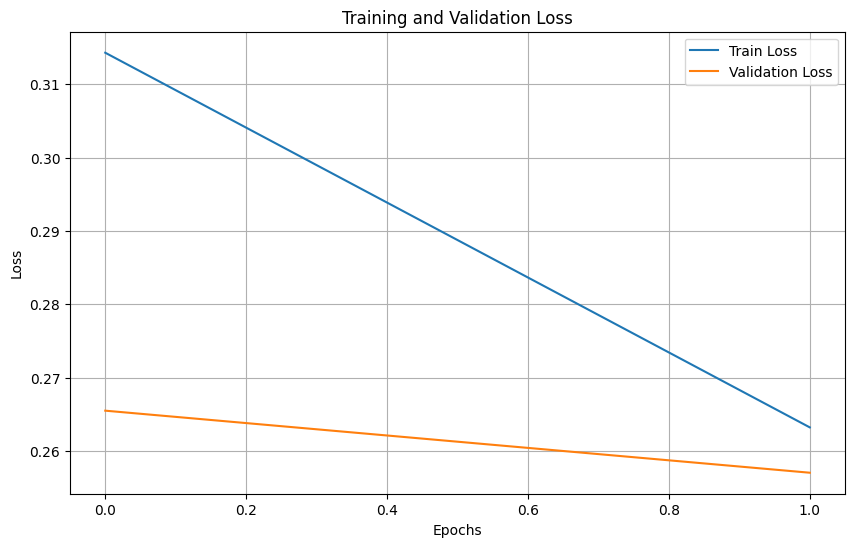

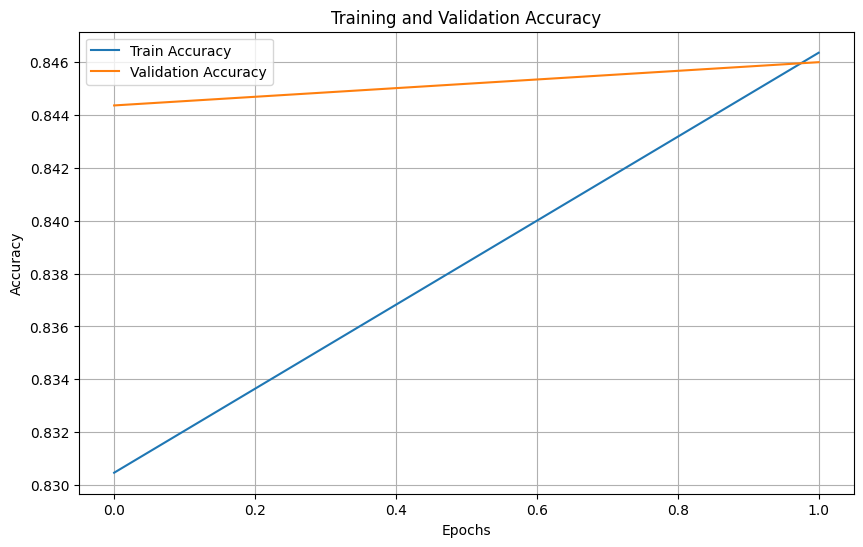

In [9]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08)

# Metrics for monitoring
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# Variable to track the best validation accuracy
best_val_accuracy = 0.0

for epoch in range(100):  # Set your desired number of epochs
    print(f"Epoch {epoch + 1}/2")
    print("-" * 30)

    # Initialize epoch-specific metrics
    epoch_train_loss = tf.keras.metrics.Mean(name='train_loss')
    epoch_val_loss = tf.keras.metrics.Mean(name='val_loss')

    # Training
    for step, (images, labels) in enumerate(train_data):
        images = tf.expand_dims(images, axis=0)  # Add batch dimension to input
        labels["cell_mask"] = tf.expand_dims(labels["cell_mask"], axis=0)  # Add batch dimension to target

        with tf.GradientTape() as tape:
            predictions = model(images, training=True)  # Forward pass
            loss = loss_fn(labels["cell_mask"], predictions)  # Compute loss
        
        # Backpropagation
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Update training metrics
        epoch_train_loss.update_state(loss)
        train_accuracy.update_state(labels["cell_mask"], predictions)

        # Print step logs
        # if step % 10 == 0:
        #     print(f"Step {step}: Loss = {loss.numpy():.4f}, Accuracy = {train_accuracy.result().numpy():.4f}")

    # Validation
    for step, (images, labels) in enumerate(test_data):
        images = tf.expand_dims(images, axis=0)  # Add batch dimension to input
        labels["cell_mask"] = tf.expand_dims(labels["cell_mask"], axis=0)  # Add batch dimension to target

        predictions = model(images, training=False)
        val_loss = loss_fn(labels["cell_mask"], predictions)
        epoch_val_loss.update_state(val_loss)
        val_accuracy.update_state(labels["cell_mask"], predictions)

    # Log epoch results
    train_loss = epoch_train_loss.result().numpy()
    val_loss = epoch_val_loss.result().numpy()
    current_val_accuracy = val_accuracy.result().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy.result().numpy())
    val_accuracies.append(val_accuracy.result().numpy())

    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy.result().numpy():.4f}, "
          f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {current_val_accuracy:.4f}")

    # Save the best model
    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy
        model.save_weights('best_model.weights.h5')
        print(f"New best model saved with Validation Accuracy = {best_val_accuracy:.4f}")

    # Reset metrics for the next epoch
    train_accuracy.reset_state()
    val_accuracy.reset_state()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


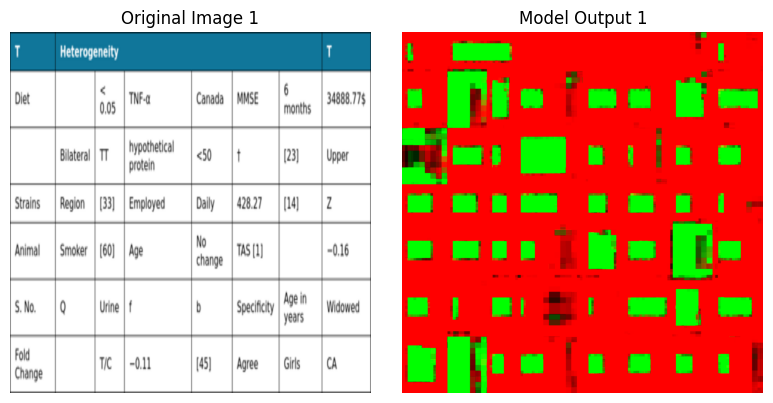

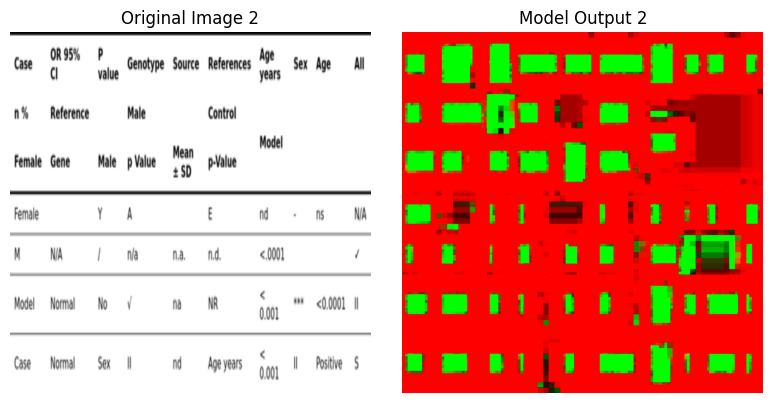

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import glob
import os

# Define the custom decoder
@tf.keras.utils.register_keras_serializable(package="Custom", name="cell_decoder")
class cell_decoder(tf.keras.layers.Layer):
    def __init__(self, name="cell_mask", trainable=True, dtype=None, **kwargs):
        super().__init__(name=name, trainable=trainable, dtype=dtype, **kwargs)
        self.conv1 = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')
        self.drop = Dropout(0.8)
        self.conv2 = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2, 2))
        self.upsample4 = UpSampling2D(size=(2, 2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same', name='cell_mask')

    def call(self, X):
        input, pool_3, pool_4 = X[0], X[1], X[2]
        result = self.conv1(input)
        result = self.drop(result)
        result = self.conv2(result)
        result = self.upsample1(result)
        result = Concatenate()([result, pool_4])
        result = self.upsample2(result)
        result = Concatenate()([result, pool_3])
        result = self.upsample3(result)
        result = self.upsample4(result)
        result = self.convtraspose(result)
        return result

# Define the architecture
def create_model():
    inputShape = (1024, 1024, 3)
    inputs = Input(shape=inputShape, name='input')

    # Import pre-trained VGG19 model
    vgg_19 = tf.keras.applications.VGG19(input_tensor=inputs, include_top=False, weights='imagenet', pooling=None)

    # Add two (1x1) convolutional layers with dropout
    x = Conv2D(512, (1, 1), activation='relu', name='block6_conv1')(vgg_19.output)
    x = Dropout(0.8, name='block6_dropout1')(x)
    x = Conv2D(512, (1, 1), activation='relu', name='block6_conv2')(x)
    x = Dropout(0.8, name='block6_dropout2')(x)

    # Get feature maps from VGG19
    block3_pool = vgg_19.get_layer('block3_pool').output
    block4_pool = vgg_19.get_layer('block4_pool').output

    # Encoder result
    encoder_result = [x, block3_pool, block4_pool]

    # Add custom cell decoder
    Cell_Decoder = cell_decoder()
    output = Cell_Decoder(encoder_result)

    # Define the full model
    model = Model(inputs=inputs, outputs=output, name="cellnet")
    return model

# Function to preprocess images
def preprocess_image(image_path, target_size=(1024, 1024)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Decode PNG
    image = tf.image.resize(image, target_size)  # Resize to target size
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Function to test the model
def test_model_one_by_one(model, image_paths):
    for i, image_path in enumerate(image_paths):
        # Preprocess the image
        image = preprocess_image(image_path)
        image = tf.expand_dims(image, axis=0)  # Add batch dimension

        # Predict using the model
        prediction = model(image, training=False)

        # Display results
        plt.figure(figsize=(8, 4))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(image[0].numpy())
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # Model Output
        plt.subplot(1, 2, 2)
        plt.imshow(tf.squeeze(prediction[0]).numpy(), cmap='binary')  # Convert to binary colormap
        plt.title(f"Model Output {i+1}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Main function
if __name__ == "__main__":
    # Specify weights and dataset directory
    weights_path = "/kaggle/input/tablenet_p2/keras/default/1/best_model.weights.h5"  # Replace with your model's weights file path
    dataset_dir = "/kaggle/input/novelty-3/Novetly_1/val_1"  # Replace with your dataset directory path

    # Ensure the weights file exists
    if not os.path.exists(weights_path):
        print(f"Error: Weights file not found at {weights_path}")
        exit()

    # Ensure the dataset directory exists
    if not os.path.exists(dataset_dir):
        print(f"Error: Dataset directory not found at {dataset_dir}")
        exit()

    # Load the model architecture and weights
    model = create_model()
    model.load_weights(weights_path)

    # Get image paths
    image_paths = glob.glob(f"{dataset_dir}/*.png")
    if len(image_paths) == 0:
        print(f"No images found in directory {dataset_dir}")
        exit()

    # Test the model on images one by one
    test_model_one_by_one(model, image_paths[:2])  # Process first two images
